# RIST Internship Test - Nichita Uțiu
In this document we will try to train a model to predict the type of a sorting algorithm based on a visual representation of it over 42 iterations on a vector of 10 elements(each iteration being a swap).

In [1]:
%matplotlib inline
# import needed libraries
# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# needed for image export
import PIL

# sklearn
from sklearn import preprocessing

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

## 1. Extracting the Data

In [2]:
algorithms_df = pd.read_csv('./data.csv')  # load the data from  the csv
algorithms_df.describe()  # view a short summary

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.500000,0.492175,0.498129,0.512111,0.500150,0.497343,0.503398,0.498808,0.489210,0.510043,...,0.499388,0.500035,0.500087,0.498844,0.497845,0.497845,0.498844,0.500087,0.500035,0.499388
std,2.872425,0.293948,0.290994,0.294248,0.290129,0.280255,0.288480,0.290329,0.290039,0.285080,...,0.416720,0.337148,0.261106,0.194865,0.151147,0.151147,0.194865,0.261106,0.337148,0.416720
min,0.000000,0.000400,0.000500,0.000300,0.001200,0.000300,0.000000,0.000100,0.000400,0.001800,...,0.000000,0.002900,0.015400,0.062500,0.085000,0.085000,0.062500,0.015400,0.002900,0.000000
25%,2.000000,0.232000,0.253100,0.253100,0.253975,0.259150,0.254000,0.237625,0.243000,0.268175,...,0.065600,0.163250,0.256525,0.341550,0.392675,0.392675,0.341550,0.256525,0.163250,0.065600
50%,4.500000,0.491900,0.490000,0.512050,0.494800,0.496650,0.512950,0.500700,0.483250,0.513550,...,0.458600,0.486250,0.506850,0.502200,0.497650,0.497650,0.502200,0.506850,0.486250,0.458600
75%,7.000000,0.751150,0.750525,0.771700,0.752225,0.735500,0.749125,0.746925,0.732625,0.750600,...,0.933675,0.842000,0.738300,0.650725,0.607250,0.607250,0.650725,0.738300,0.842000,0.933675
max,9.000000,1.000000,0.997700,0.999400,0.999800,0.996100,0.997400,0.998200,0.999300,0.999500,...,1.000000,0.993900,0.987100,0.942800,0.890600,0.890600,0.942800,0.987100,0.993900,1.000000


### 1.1 Splitting and looking at the data

In [3]:
Y = algorithms_df['label'].astype(int)  # the labels
X = algorithms_df.drop('label', axis=1)  # everyhing but the labels

# count by label
print("Number of labels = {}".format(Y.unique().size))

# iterate over the label,count pairs
# use sort_index as value_counts returns them unordered
for ind, cnt in Y.value_counts().sort_index().iteritems():
    print("Samples with label {}: {}".format(ind, cnt))

Number of labels = 10
Samples with label 0: 1000
Samples with label 1: 1000
Samples with label 2: 1000
Samples with label 3: 1000
Samples with label 4: 1000
Samples with label 5: 1000
Samples with label 6: 1000
Samples with label 7: 1000
Samples with label 8: 1000
Samples with label 9: 1000


## 2. Sample inspection

In [4]:
def get_order(arr):
    """Returns whether the elements of the given numpy
    array are ascending, descending or unordered.
    
    :return `-1` if descending, `1` if ascending, `0` if
    ordered
    """
    # compare elements pairwise
    # using numpy for vectorisation
    if np.all(arr[:-1] <= arr[1:]):
        return 1 # ascending 
    if np.all(arr[:-1] >= arr[1:]):
        return -1 # descending 
    return 0

def get_samp_order(samp, width):
    """Recives a sample and returns it's last row's
    order. Receives the width of the rows, considering
    the image is unrolled."""
    return get_order(samp[-width:])

def get_image_from_sample(samp, width):
    """Returns a PIL grayscale image from the sample"""
    # normalize the values to a set of equally spaced values
    # in the (0, 255) interval, to maximize visibility
    # we'll be using sklearn's label encoder for this
    
    le = preprocessing.LabelEncoder()
    norm_samp = le.fit_transform(samp) * 255 / (width-1)
    norm_samp = norm_samp.astype('uint8')
    
    # convert the array to a pil "luminance" image
    img =  PIL.Image.new('L', (width, samp.size // width))  # greyscale
    img.putdata(norm_samp)
    return img

**Exmaple:**

Sample 236 order: 1 
Last row = [ 0.056   0.0636  0.16    0.4325  0.4564  0.5976  0.6092  0.6958  0.7046
  0.8454]


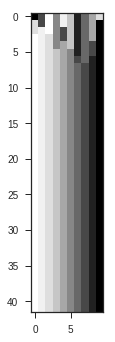

In [5]:
SAMPLE_IND = 236
IMG_WIDTH = 10

# get the sample
sample = X.iloc[SAMPLE_IND].values

order = get_samp_order(sample, IMG_WIDTH)
print("Sample {} order: {} ".format(SAMPLE_IND, order))
print("Last row = {}".format(sample[-IMG_WIDTH:]))  # get the last row

# get image from array
img = get_image_from_sample(sample, IMG_WIDTH)
plt.imshow(img)

# save to png
img.save("algo.png")

## 3. Feature extraction
### 3.1 FTD, FTP, NIT, RPA
#### 3.1.1 Extraction

In [6]:
def extract_ftds(samps, width):
    """Extracts for each sample, the first row where
    each each element changes its initial position.
    
    :returns a matrix of where each row is the features
    of each sample
    """
    # define the function for a single row
    def extract_ftd(samp):
        img = samp.reshape((-1, width)) # reverse into a matrix
        # check what elements on each row are dfferent to the first
        # that means that the first True value is the first swap
        changes = img != img[0]
        # return the row index of the change
        return np.argmax(changes, axis=0)
    # vectorize it
    return np.apply_along_axis(extract_ftd, 1, samps)
 
    
def extract_ftps(samps, width):
    """Extracts for each sample, the first row where
    each element reaches it's final position.
    
    :returns a matrix of where each row is the features
    of each sample"""
    # same as above
    def extract_ftp(samp):
        img = samp.reshape((-1, width))
        # however this time check them in reverse
        changes = (img != img[-1])[::-1, :]
        # return the row index of the change
        # substract from len to get the actual postion
        return changes.shape[0] - np.argmax(changes, axis=0)

    return np.apply_along_axis(extract_ftp, 1, samps)


def extract_rpas(samps, width):
    """Extracts for each sample, the area of image
    where the algorithm is active.
    
    :returns a matrix of the areas for each
    corresponding row"""
    # use the ftp features, sum them to get the active
    # note: the vectorized computation is fast enough
    # not to warrant precalculating ftp
    return extract_ftps(samps, width).sum(axis=1)[:, np.newaxis]


def extract_nits(samps, width):
    """Extract, for each sample, the number of iterations
    needed to reach the end of the algorithm
    
    :returns a matrix of the values, each row orresponding to
    a sample
    """
    # compute it similarly to the ftp values, but find the 
    # first row not equal to the last one
    def extract_nit(samp):
        img = samp.reshape((-1, width))
        # any item that is different from the final state
        # means the algorithm is still active
        changes = np.any((img != img[-1])[::-1, :], axis=1)
        return changes.size - np.argmax(changes)
    
    # vectorize and turn back to a matrix
    return np.apply_along_axis(extract_nit, 1, samps)[:, np.newaxis]

#### 3.1.2 Example
Extract FTD, FTP, NIT and RPA for *SAMPLE_INDEX*

Extracted features:
FTP = [[3 2 3 5 4 5 7 7 6 1]]
FTD = [[1 2 3 5 2 5 6 7 4 1]]
NIT = [[7]]
RPA = [[43]]


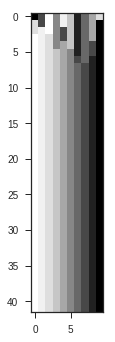

In [7]:
sample = X.iloc[SAMPLE_IND].values[np.newaxis, :]

ftp = extract_ftps(sample, IMG_WIDTH)
ftd = extract_ftds(sample, IMG_WIDTH)
nit = extract_nits(sample, IMG_WIDTH)
rpa = extract_rpas(sample, IMG_WIDTH)

print("Extracted features:")
print("FTP = {}".format(ftp))
print("FTD = {}".format(ftd))
print("NIT = {}".format(nit))
print("RPA = {}".format(rpa))

plt.imshow(img);

### 3.2 Additional Features
To extract more info from he given features and increase the variance of our samples, we can:

* Add a one-hot encoded feature from the order of the last row. This one would be linearly correlated to whether the algorithm is ascending or descending.(**Note:** Is this considered cheating?)

* Compute for each element, the time between the first displacement and the time it reaches its last position.
(**Note**: Is there an issue of this being a linear combination of the orther features?)

* Compute the distance of each swap between every consecutive row. Diferent algorithm might do swaps differently.

* Lastly, it could probably help if the values are normalize to an interval and equally spaced so that we extract only the relative order and not the absolut values, reducing noise.

#### 3.2.1 Implementation:

In [8]:
def extract_orders_one_hot(samps, width):
    """Extracts the order of the samples as 
    a matrix of one-hot-encoded values of the 
    order of the last row
    
    :returns a matrix of the values, each row 
    corresponding to a sample
    """
    
    # use the predefined function, but vectorize it
    # needs positive values so add one
    row_func = lambda samp: get_samp_order(samp, width) + 1
    samp_orders = np.apply_along_axis(row_func, 1, samps)
    
    # convert it back to a matrix from a vector
    samp_orders = samp_orders.reshape((-1, 1))
    
    # use sklearn for one-hot encoding
    # do not generate sparse matrix
    oh_encoder = preprocessing.OneHotEncoder(sparse=False)
    return oh_encoder.fit_transform(samp_orders)


def extract_displacements(samps, width):
    """Returns the displacement for each element 
    of the array(the differene between FTD and FTP)
    
    :returns a matrix of the features for each
    element of the array on each row"""
    return extract_ftps(samps, width) - \
        extract_ftds(samps, width)


def extract_swap_dists(samps, width):
    """Extracts the distances of swaps between
    consecutive rows. The distance is 0 if no 
    swap occured.
    
    :returns a matrix of the values, each row 
    having nrrows-1 columns, each representing 
    the distance of a swap."""
    def extract_swap_dist(samp):
        img = samp.reshape((-1, width))
        # each row will have a truth value where
        # the swapped values are
        swaps = img[:-1] != img[1:]
        
        # every pair is the positions on the row
        # so sumbstract them to get the distance
        pos = np.nonzero(swaps)[1]
        swap_lengths = np.abs(pos[::2] - pos[1::2])
        
        # pad the result with 0 to make them of equal 
        result = np.zeros(img.shape[0]-1)  # length(41 in this case)
        result[:swap_lengths.size] = swap_lengths
        return result
    
    # vectorize and turn back to a matrix
    return np.apply_along_axis(extract_swap_dist, 1, samps)


def extract_norm_samps(samps, width):
    """For each image, extract the pixel values,
    but normalized to the integer inteval 1, 2 ...width.
    
    :returns a matrix of the normlized samples, each row
    corresponding to each sample"""
    def extract_norm_samp(samp):
        # normalize using sklearn's label encoder
        le = preprocessing.LabelEncoder()
        return le.fit_transform(samp)
    
    return np.apply_along_axis(extract_norm_samp, 1, samps)

#### 3.2.2 Example
Extract the bonus features for *SAMPLE_INDEX*

Extracted features:
ORDERS = [[ 1.]]
DISPLACEMENTS = [[2 0 0 0 2 0 1 0 2 0]]
DISTS = [[ 9.  3.  2.  4.  2.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]]
NORM = [[9 7 0 5 1 3 8 6 4 2 2 7 0 5 1 3 8 6 4 9 2 1 0 5 7 3 8 6 4 9 0 1 2 5 7 3 8
  6 4 9 0 1 2 5 4 3 8 6 7 9 0 1 2 3 4 5 8 6 7 9 0 1 2 3 4 5 7 6 8 9 0 1 2 3
  4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0
  1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7
  8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4
  5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
  2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8
  9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5
  6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2
  3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 

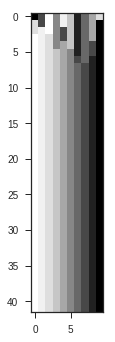

In [9]:
sample = X.iloc[SAMPLE_IND].values[np.newaxis, :]

orders_one_hot = extract_orders_one_hot(sample, IMG_WIDTH)
displacements = extract_displacements(sample, IMG_WIDTH)
dists = extract_swap_dists(sample, IMG_WIDTH)
norm = extract_norm_samps(sample, IMG_WIDTH)

print("Extracted features:")
print("ORDERS = {}".format(orders_one_hot))
print("DISPLACEMENTS = {}".format(displacements))
print("DISTS = {}".format(dists))
print("NORM = {}".format(norm))

print("Image for reference:")
plt.imshow(img);  

In [10]:
def df_from_prefix(vals, prefix):
    """Creates a dataframe from the given values
    where the columns are numbered prefix0, prefix1
    ... prefixn-1 where n is th enumber of columns"""
    if vals.shape[1] == 1:
        col_names = [prefix]  #if only one do not append number
    else:
        col_names = ['{0}{1}'.format(prefix, ind) 
                     for ind in range(vals.shape[1])]
    return pd.DataFrame(vals, columns=col_names)

def extract_features(df, width):
    """Receives the dataframe of features and returns 
    the dataframe of correspponding extracted features"""
    vals = df.values
    
    # required
    ftd = extract_ftds(vals, width)
    ftp = extract_ftps(vals, width)
    rpa = extract_rpas(vals, width)
    nit = extract_nits(vals, width)
    
    # bonus
    orders_one_hot = extract_orders_one_hot(vals, width)
    displacements = extract_displacements(vals, width)
    dists = extract_swap_dists(vals, width)
    norm = extract_norm_samps(vals, width)
    
    # map the featues to their column names
    mapping = {
        'ftd': ftd,
        'ftp': ftp,
        'rpa': rpa,
        'nit': nit,
        'ord': orders_one_hot,
        'norm': norm,
        'dist': dists,
        'disp': displacements
    }
    # convert to dataframes and concatenate
    dataframes = [df_from_prefix(mat, col) 
                  for col, mat in mapping.items()] 
    return pd.concat(dataframes, axis=1) # col-wise


### ADD IT TO THE DATAFRAME
X_feat = pd.concat([X, extract_features(X, IMG_WIDTH)], axis=1)
X_feat = pd.concat([X_feat, Y.rename('label')], axis=1)

## 4. Visualizations
### 4.1 NIT

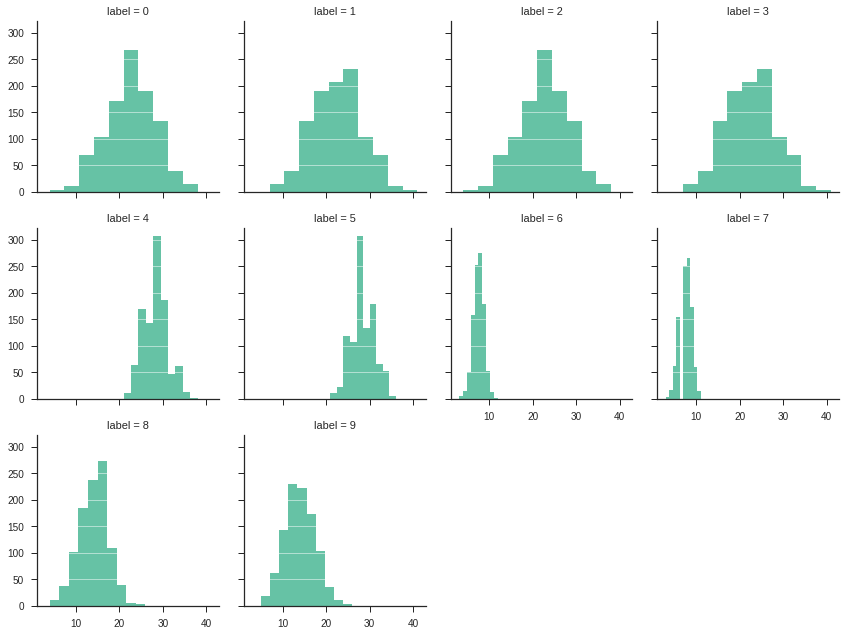

In [11]:
# using facet grid to 
g = sns.FacetGrid(X_feat, col='label', col_wrap=4)
g = g.map(plt.hist, 'nit', zorder=-3)

# add horizontal lines for better visualization
g = g.map(plt.grid, axis='y', color='white', linestyle='-', linewidth=0.5)

### 4.2 RPA

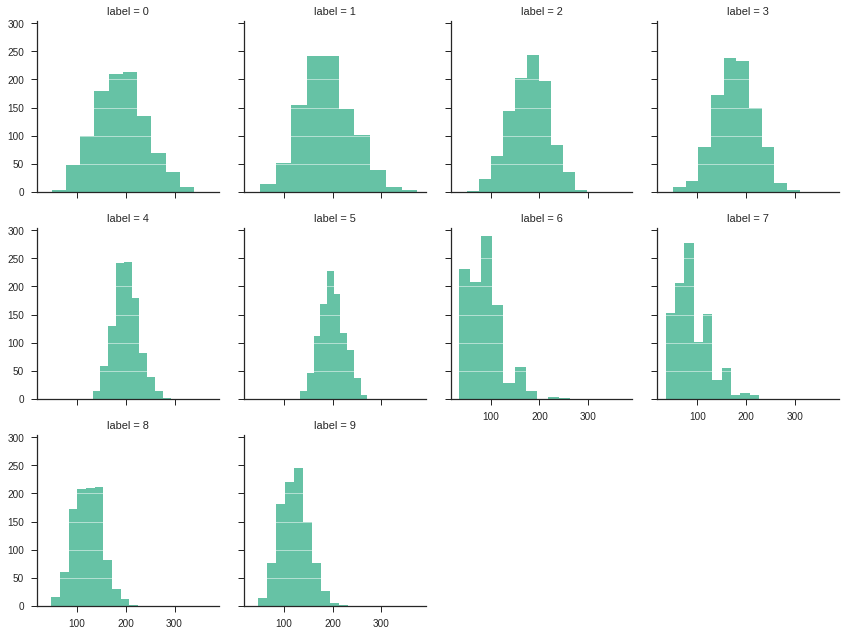

In [12]:
# using facet grid to 
g = sns.FacetGrid(X_feat, col='label', col_wrap=4)
g = g.map(plt.hist, 'rpa', zorder=-3)

# add horizontal lines for better visualization
g = g.map(plt.grid, axis='y', color='white', linestyle='-', linewidth=0.5);

### 4.3 Statistics
Show the means, standard deviations for each algorithm. 

In [13]:
# algorithm mapping
label_algo_map = {
    0: 'insertion', 1: 'insertion',
    2: 'bubble', 3: 'bubble',
    4: 'heap', 5: 'heap',
    6: 'quick', 7: 'quick',
    8: 'random', 9: 'random'
}

X_feat['algo'] = X_feat['label'].map(label_algo_map)
gr_by_algo = X_feat.groupby('algo').agg(['std', 'mean'])[['nit', 'rpa']]

print('NIT and RPA statistics')
gr_by_algo

NIT and RPA statistics


nit                 rpa          
                std     mean        std      mean
algo                                             
bubble     5.582165  22.4965  40.012985  178.5235
heap       2.666772  28.2615  25.020169  200.0875
insertion  5.582165  22.4965  51.387389  188.4760
quick      1.428903   7.5160  33.982714   88.9905
random     3.335686  14.0355  28.523842  122.1215

#### 4.3.1 Bonus - Box Plots
For bettter visualizations.

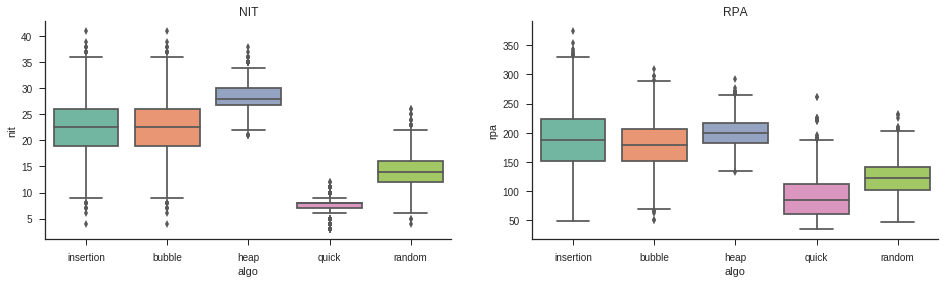

In [17]:
# plot rpa and nit side by side 
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

sns.boxplot(ax=axes[0], x='algo', y='nit', data=X_feat)
sns.boxplot(ax=axes[1], x='algo', y='rpa', data=X_feat)
axes[0].set_title('NIT')
axes[1].set_title('RPA')
sns.despine()

### 4.4 Bonus(FTP & FTD Statistics)
Compute the standard deviation and mean for each vaulue of FTP and FTD

In [21]:
gr_by_algo = X_feat.groupby('label').agg(['std', 'mean'])

print("FTP Statistics")
gr_by_algo.filter(regex='ftp.*')  # select all ftp columns

FTP Statistics


ftp0               ftp1               ftp2               ftp3  \
             std    mean        std    mean        std    mean        std   
label                                                                       
0      12.844699  14.867   9.155065  16.314   7.907929  17.851   7.131129   
1      12.577796  14.557   9.084013  15.665   7.854927  17.768   7.093913   
2      11.486164  20.437   7.532252  21.411   6.449936  21.411   6.010004   
3      11.360842  20.177   7.983306  20.669   6.497482  21.288   5.950202   
4       2.703463  28.314   2.703463  28.314   2.625889  26.699   2.624288   
5       2.629874  28.209   2.632963  28.206   2.561765  26.589   2.560913   
6      12.143700   8.655  12.058498   8.494  11.774253   8.760  10.803338   
7      11.571070   8.235  11.795285   8.213  12.026081   8.998  11.364243   
8      11.416234  12.589   8.339106  12.707   6.041972  12.009   5.454369   
9      11.059828  12.254   7.137566  12.110   6.555850  12.197   6.283868   

                    ftp4               ftp5               ftp6          \
         mean        std    mean        std    mean        std    mean   
label                                                                    
0      19.184   6.409607  19.895   5.921169  20.104   5.409588  20.175   
1      19.189   6.469541  19.870   5.946215  20.083   5.507661  20.100   
2      21.187   5.516165  20.566   5.076863  19.329   4.539129  17.554   
3      21.150   5.554945  20.538   5.119161  19.299   4.465400  17.512   
4      24.700   2.605590  22.383   2.564701  19.878   2.539568  17.138   
5      24.591   2.534000  22.292   2.489996  19.761   2.466894  17.039   
6       8.551  10.949118   9.052  10.608842   9.032  11.435557   9.702   
7       8.873  11.930090   9.778  11.290088   9.537  10.741218   9.140   
8      12.103   5.448074  12.276   5.901961  12.367   6.317756  12.374   
9      12.433   6.020270  12.314   5.945887  12.424   5.501731  12.185   

            ftp7               ftp8               ftp9          
             std    mean        std    mean        std    mean  
label                                                           
0       5.168593  19.934   5.225792  19.602   7.973373  20.970  
1       5.320555  19.900   5.314699  19.635   8.226248  21.289  
2       3.929407  15.101   3.780247  11.745   9.927312  10.245  
3       4.015834  15.101   3.910264  11.682  10.395626  10.645  
4       2.521661  14.172   2.503218  11.142   2.457658   7.866  
5       2.452629  14.068   2.452597  11.028   2.417861   7.786  
6      10.846396   9.188  11.700649   9.439  11.050801   7.661  
7      11.345797   9.625  10.859308   8.942  11.543744   8.106  
8       6.008388  12.124   7.502261  12.037  10.524813  11.467  
9       6.443348  12.528   7.238370  11.820  10.841444  11.925

In [19]:
print("FTD Statistics")
gr_by_algo.filter(regex='ftd.*')

FTD Statistics


ftd0             ftd1             ftd2             ftd3         \
            std   mean       std   mean       std   mean       std   mean   
label                                                                       
0      4.284155  2.787  1.670446  1.420  1.132637  1.696  1.173647  2.577   
1      3.727432  2.512  1.905158  1.502  0.906530  1.645  1.017010  2.582   
2      7.558132  5.887  3.783764  2.393  2.247151  2.058  1.586504  2.461   
3      6.924887  5.667  3.921878  2.516  2.140225  2.004  1.273551  2.383   
4      1.543507  1.813  1.494666  1.547  4.408311  3.885  2.405930  2.767   
5      1.657906  1.936  1.085287  1.427  4.138481  3.790  2.297009  2.805   
6      1.177619  2.199  1.871223  2.295  2.005442  2.715  2.054648  3.262   
7      1.171312  2.201  1.822251  2.189  2.004299  2.798  2.004329  3.209   
8      3.081585  3.573  3.339832  4.026  3.020374  3.908  2.877895  4.002   
9      3.217133  3.602  3.343291  4.172  3.130696  4.112  3.050772  4.090   

           ftd4             ftd5             ftd6              ftd7          \
            std   mean       std   mean       std    mean       std    mean   
label                                                                         
0      1.504726  4.008  2.109372  6.001  2.644400   8.488  3.373328  11.506   
1      1.516251  4.091  2.106379  6.098  2.635193   8.552  3.406272  11.446   
2      1.304321  3.107  1.272957  3.851  1.144074   4.602  1.102240   5.409   
3      1.293235  3.096  1.293673  3.922  1.123850   4.668  1.125018   5.460   
4      5.072986  6.112  7.428604  9.355  6.117878  10.751  3.771729   6.733   
5      5.263323  6.127  7.367989  9.045  6.046023  10.358  3.695177   6.639   
6      2.184409  3.623  2.262972  3.741  2.315504   3.599  2.486341   3.483   
7      2.197122  3.559  2.259677  3.658  2.361841   3.722  2.545677   3.503   
8      3.135636  4.296  3.089327  4.060  2.982846   3.977  2.959398   4.061   
9      2.933548  4.070  2.988844  3.912  3.090554   4.145  3.137965   4.155   

           ftd8              ftd9          
            std    mean       std    mean  
label                                      
0      4.265878  15.022  7.048305  17.274  
1      4.281947  14.792  7.286574  17.173  
2      1.201430   6.247  2.301499   6.549  
3      1.205609   6.281  2.404775   6.529  
4      2.859474   7.672  2.276710   6.924  
5      2.911675   7.925  2.214882   6.802  
6      2.609015   3.207  2.354000   2.365  
7      2.434526   3.003  2.366368   2.352  
8      3.293419   4.171  2.992609   3.557  
9      3.089942   3.947  3.157373   3.658

### 4.5 Interpretation
As we can see from the expected value of NIT, quick sort is significantly faster than the $n^2$ ones, and slightly faster than random sort. This means  tha NIT is a good feature to differentiate between algorithms, and would make quick sort prediction more accurate, especially due to it's low standard deviation. However, insertion and bubble sort do not differ at all in this regard, as it's to be expected from their average case performance.

Similar conclusions can be drawn from the RPA statistics, which is to be expected as the RPA of an algorithm is less than or equal to $NIT * 10$, and similar convergence rates would mean similar areas, as the same type of algorithms should also be more likely to converge in the same fashion, as it can be seen in the visual representation. However, quick sort is not as predictable as it has a greater standard deviation and thus overlaps with random sort. There also is a slight difference between inserition and bubble sort, the latter having a smaller active area overall.

**Note:** Random sort seems to be surprisngly efficient, however, given the samm size of the sorted array, there is a greater chance for elelmnts to land on their proper positions.

The histograms, are all relatively normally distributed, so they do not give much information that can not be extracted from the expected values and standard deviations alone. We can see though both the ascending and descending versions of the algorithms, and we can see that both the versions are very similarly distributed, both in terms of RPA and NIT.

From the expected values and standard deviations of FTP and FTD we can also see that iterative algorithms, such as insertion and bubble have higher values at the beginning of the array then at the end. Quicksort is more symmetric, being a divide-et-impera algorithm. Random, is, as expected, unpredictable.